In [1]:
import torch

from tqdm.auto import tqdm

from point_e.diffusion.configs import diffusion_from_config
from point_e.models.configs import model_from_config
from point_e.config import MODEL_CONFIGS,DIFFUSION_CONFIGS

from point_e.utils.download import load_checkpoint
from point_e.diffusion.sampler import PointCloudSampler
from point_e.utils.plotting import plot_point_cloud

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base300M'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...


/media/aioz-nghiale/data/Proj/point_e_revised/point_e/utils/download.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=device)


downloading upsampler checkpoint...


<All keys matched successfully>

In [3]:
guidance_scale = [3.0, 0.0]
num_points=[1024, 4096 - 1024]

sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=num_points,
    aux_channels=['R', 'G', 'B'],
    guidance_scale=guidance_scale,
    model_kwargs_key_filter=('images', ''), # Do not condition the upsampler at all
    use_karras = (False,False)
)

In [4]:
pre_noise = []
for (stage_pt,guide_scale) in zip(num_points,guidance_scale):
    batch_size = 1
    sample_shape = (batch_size, 3 + len(sampler.aux_channels), stage_pt)
    internal_batch_size = batch_size
    if guide_scale:
        internal_batch_size *= 2
    pre_noise.append(
        torch.randn(*(internal_batch_size, *sample_shape[1:]))
    )

In [5]:
from diff_conditioning import OriginDistanceCond, SoftzooSimulation

config = SoftzooSimulation.load_config('custom_cfg.yaml')
cond_cls = SoftzooSimulation(
    config = config,
    grad_scale=1e-1,
    calc_gradient=True
)

cond_fn_lst = [cond_cls.calculate_gradient, None]

# cond_cls = OriginDistanceCond(
#     grad_scale=1e-5,
#     calc_gradient=False
# )
# cond_fn_lst = [cond_cls.calculate_gradient, None]

# cond_fn_lst = [None,None]

[Taichi] version 1.4.1, llvm 15.0.4, commit e67c674e, linux, python 3.10.0
[I 08/18/25 15:37:00.427 305606] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Taichi] Starting on arch=cuda
Voxelizer resolution [128, 128, 128]
loading /media/aioz-nghiale/data/Data/mujoco_scanned_objects/models/5_HTP/model.obj
N particles: 69920
M substeps: 7000
M substeps (local): 20


In [6]:
from PIL import Image
# Set a prompt to condition on.
img = Image.open('asset/hand.jpg')

# Produce a sample from the model.
samples_set = []
final_sample = None
count = 0
for x in tqdm(sampler.sample_batch_progressive(
    batch_size=1, model_kwargs=dict(images=[img]),
    pre_noise=pre_noise,
    cond_fn_lst=cond_fn_lst
)):
    
    if count%32 == 0: samples_set.append(x)
    final_sample = x
    count+=1

samples_set.append(final_sample)
len(samples_set)

0it [00:00, ?it/s]

Forward #0000: 100%|██████████| 100/100 [00:07<00:00, 13.27it/s]


17

In [7]:
from point_e.utils.point_cloud import PointCloud
from point_e.utils.path import LOG_DIR
import os

SAMPLE_NAME = 'hand_normal_ddim252_1e-1'

pc_set = [sampler.output_to_point_clouds(sample)[0] for sample in samples_set]

PointCloud.write_batch_ply(pc_set,SAMPLE_NAME)

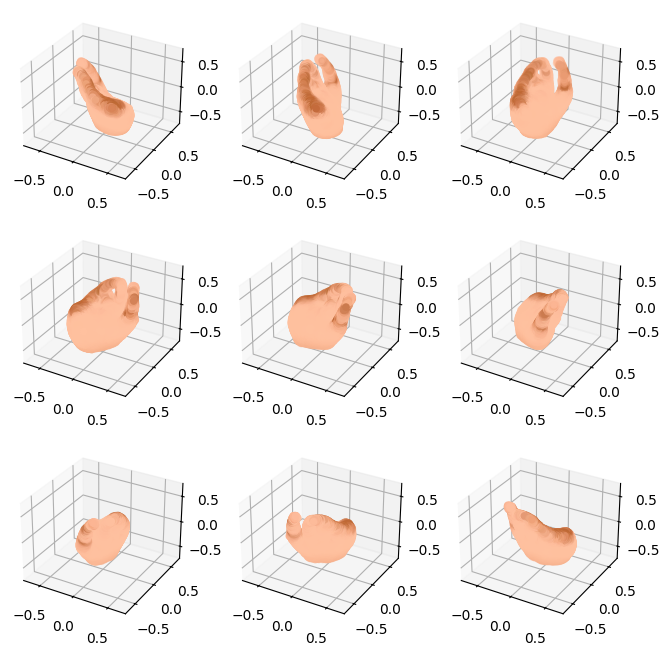

In [8]:
pc = sampler.output_to_point_clouds(samples_set[-1])[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [9]:
grad_mean = torch.stack([grad_tens.mean() for grad_tens in cond_cls.grad_lst],dim = 0).tolist()
loss_mean = torch.stack([torch.tensor(loss_tens[0][-1]) for loss_tens in cond_cls.loss_lst],dim = 0).tolist()

with open(f'logs/{SAMPLE_NAME}/log_{SAMPLE_NAME}.json','w') as f:
    print({
        "grad_mean":grad_mean,
        "loss_mean":loss_mean
    },file=f)